In [16]:
from math import exp, pi
import numpy as np
import matplotlib.pyplot as plt

# カーネル密度推定（２次元）

In [139]:
def bivariate_gaussian_kernel(x,H = np.array([[1,0],[0,1]])):
    '''
    x: np.array with size:(2,1)
    H: bandwidth
    RETURN: scalar
    '''
    Hinv = np.linalg.inv(H)
    return exp(-x.T@Hinv@x/2)*((2*pi*np.linalg.det(H))**(-1/2))

In [45]:
x = np.array([[0],[0]])
bivariate_gaussian_kernel(x)

0.3989422804014327

In [164]:
def plot2D(f, verbose=False):
    plt.figure(figsize=(5,5))
    n = int(4/0.05)
    x = np.arange(-2, 2, 0.05) #x軸の描画範囲の生成。0から10まで0.05刻み。
    y = np.arange(-2, 2, 0.05) #y軸の描画範囲の生成。0から10まで0.05刻み。
    X, Y = np.meshgrid(x, y)
    Z = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            z = np.array([[x[i]],[y[j]]])
            Z[i][j] = f(z)    
    # 等高線図の生成。
    cont=plt.contour(X,Y,Z,colors=['black'])
    cont.clabel(fmt='%1.1f', fontsize=14)
    
    plt.show()
    return Z if verbose else None

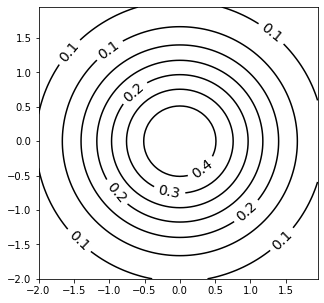

In [84]:
plot2D(bivariate_gaussian_kernel)

In [94]:
def KDE(data):
    '''
    data: n samples, np.array, size:(n,d)
    '''
    n = len(data)
    def estimator(x_):
        '''
        x : np.array, 2-dim
        data[i].T: np.array, 2-dim
        '''
        return sum([bivariate_gaussian_kernel(x_-data[i].reshape(2,1)) for i in range(n)])/n
    return estimator

### 動作確認

In [105]:
sample_data = np.random.rand(5,2)-2
sample_kde = KDE(sample_data)

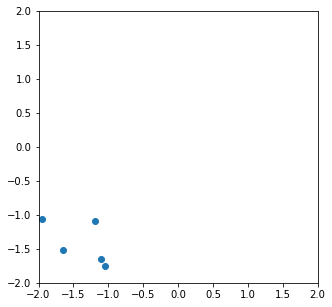

In [106]:
plt.figure(figsize=(5,5))
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.scatter(sample_data[:,0],sample_data[:,1])

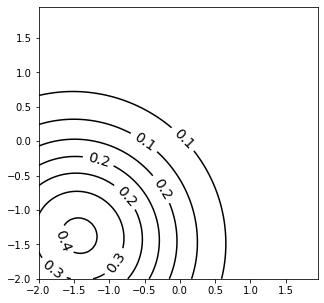

In [107]:
plot2D(sample_kde)

## interactionをlog oddsで推定できないか

In [161]:
def rule_of_thumb(data, scott=False):
    d = 2
    H_ = np.zeros((d,d))
    n = len(data)
    sigma0 = np.std(data[:,0])
    sigma1 = np.std(data[:,1])
    if scott:
        H_[0][0] = (n**(-1/(d+4)))*sigma0
        H_[1][1] = (n**(-1/(d+4)))*sigma1
    else:
        H_[0][0] = ((4/(d+2))**(1/(d+4)))*(n**(-1/(d+4)))*sigma0
        H_[1][1] = ((4/(d+2))**(1/(d+4)))*(n**(-1/(d+4)))*sigma1
    return H_

In [162]:
def OddsEstimator(data,H):
    '''
    data: n samples, np.array, size:(n,d*4)
    '''
    n = len(data)
    def estimator(x_):
        '''
        x : np.array, 2-dim
        '''
        res_list = []
        for i in range(n):
            x11, x22 = np.array([[data[i][0]],[data[i][1]]]),np.array([[data[i][2]],[data[i][3]]])
            x12, x21 = np.array([[data[i][0]],[data[i][3]]]),np.array([[data[i][2]],[data[i][1]]])
            # num_ = bivariate_gaussian_kernel(x_-x11, H)*bivariate_gaussian_kernel(x_-x22, H)
            # den_ = bivariate_gaussian_kernel(x_-x12, H)*bivariate_gaussian_kernel(x_-x21, H)
            # odds_ratio = num_/den_
            num_ = np.log(bivariate_gaussian_kernel(x_-x11, H))+np.log(bivariate_gaussian_kernel(x_-x22, H))
            den_ = np.log(bivariate_gaussian_kernel(x_-x12, H))+np.log(bivariate_gaussian_kernel(x_-x21, H))
            odds_ratio = num_-den_
            res_list.append(odds_ratio)
        return sum(res_list)/n
    return estimator

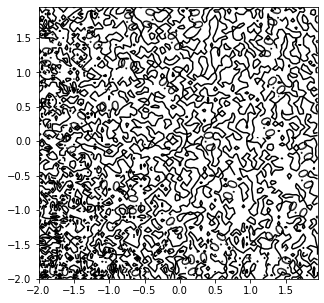

In [168]:
sample_data = np.random.rand(20,2)*2
sample_data_two = np.concatenate([sample_data[:10,:],sample_data[10:,:]],axis=1)
H = rule_of_thumb(sample_data)*1e-1

sample_oe = OddsEstimator(sample_data_two, H)
plot2D(sample_oe)